# PyTorch Model Training Fundamentals

This notebook demonstrates the essential components of training machine learning models in PyTorch, covering data handling, loss functions, optimizers, and complete training loops with monitoring.

## Learning Objectives
- Master efficient data handling with `Dataset` and `DataLoader`
- Understand various loss functions and their applications
- Explore PyTorch optimizers and hyperparameter tuning
- Implement complete training loops with TensorBoard monitoring
- Identify and prevent overfitting
- Compare PyTorch training patterns with TensorFlow equivalents

## Dataset Focus: FashionMNIST with Australian Context
We'll use FashionMNIST dataset and create Australian-themed examples for practical learning, including:
- **Australian Fashion Classification**: Classify clothing items popular in Australian fashion
- **Multilingual Labels**: English-Vietnamese fashion terminology
- **Real-world Applications**: Australian retail sentiment analysis

**FashionMNIST Classes**: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle Boot

---

## 1. Environment Setup and Runtime Detection

Following PyTorch best practices for cross-platform compatibility:

In [1]:
# Environment Detection and Setup
import sys
import subprocess
import os
import time

# Detect the runtime environment
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules or "kaggle" in os.environ.get('KAGGLE_URL_BASE', '')
IS_LOCAL = not (IS_COLAB or IS_KAGGLE)

print(f"🌐 Environment detected:")
print(f"  - Local: {IS_LOCAL}")
print(f"  - Google Colab: {IS_COLAB}")
print(f"  - Kaggle: {IS_KAGGLE}")

# Platform-specific system setup
if IS_COLAB:
    print("\n🔧 Setting up Google Colab environment...")
elif IS_KAGGLE:
    print("\n🔧 Setting up Kaggle environment...")
else:
    print("\n🔧 Setting up local environment...")

# Install required packages
required_packages = [
    "torch", "torchvision", "torchaudio",
    "matplotlib", "numpy", "tensorboard"
]

print("\n📦 Verifying required packages...")
for package in required_packages:
    if IS_COLAB or IS_KAGGLE:
        pass
    else:
        try:
            __import__(package.replace('-', '_'))
            print(f"✓ {package}")
        except ImportError:
            print(f"⚠️ Installing {package}...")
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", package],
                          capture_output=True)
            print(f"✓ {package} installed")

print("\n✅ Environment setup complete!")

🌐 Environment detected:
  - Local: False
  - Google Colab: True
  - Kaggle: False

🔧 Setting up Google Colab environment...

📦 Verifying required packages...

✅ Environment setup complete!


## 2. Core Imports and Device Detection

**Key Difference from TensorFlow**: PyTorch requires explicit device management:

In [2]:
# Core PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import platform

print(f"🔥 PyTorch {torch.__version__} ready!")
print(f"🖥️ CUDA available: {torch.cuda.is_available()}")

# Device detection function
def detect_device():
    """Detect best available PyTorch device."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        gpu_name = torch.cuda.get_device_name(0)
        print(f"🚀 Using CUDA: {gpu_name}")
        return device, f"CUDA GPU: {gpu_name}"
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device("mps")
        print(f"🍎 Using Apple Silicon MPS")
        return device, "Apple Silicon MPS"
    else:
        device = torch.device("cpu")
        cpu_count = torch.get_num_threads()
        print(f"💻 Using CPU with {cpu_count} threads")
        return device, f"CPU ({cpu_count} threads)"

DEVICE, device_info = detect_device()
print(f"\n✅ Selected device: {DEVICE}")
print(f"📊 Device info: {device_info}")

🔥 PyTorch 2.8.0+cu126 ready!
🖥️ CUDA available: False
💻 Using CPU with 1 threads

✅ Selected device: cpu
📊 Device info: CPU (1 threads)


## 3. TensorBoard Configuration

**MANDATORY**: All PyTorch training must include TensorBoard logging:

In [3]:
# TensorBoard log directory setup
def get_run_logdir(prefix="fashion_training"):
    """Generate unique log directory."""
    if IS_COLAB:
        root_logdir = "/content/tensorboard_logs"
    elif IS_KAGGLE:
        root_logdir = "./tensorboard_logs"
    else:
        root_logdir = "./tensorboard_logs"

    timestamp = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    logdir = os.path.join(root_logdir, f"{prefix}_{timestamp}")
    os.makedirs(logdir, exist_ok=True)
    return logdir

log_dir = get_run_logdir("australian_fashion")
print(f"📊 TensorBoard logs: {log_dir}")
print(f"💡 View with: tensorboard --logdir={log_dir}")

📊 TensorBoard logs: /content/tensorboard_logs/australian_fashion_2025_09_21-13_12_01
💡 View with: tensorboard --logdir=/content/tensorboard_logs/australian_fashion_2025_09_21-13_12_01


## 4. Data Handling: Dataset and DataLoader

**Core Concept**: PyTorch separates data access (`Dataset`) from data loading (`DataLoader`).

### TensorFlow vs PyTorch:
- **TensorFlow**: `tf.data.Dataset` with built-in batching
- **PyTorch**: Explicit `Dataset` + `DataLoader` + `transforms`

In [4]:
# Data transformations
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print("📥 Loading FashionMNIST dataset...")

try:
    # Download FashionMNIST
    full_trainset = torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=transform_test
    )
    print("✅ FashionMNIST downloaded successfully!")

except Exception as e:
    print(f"⚠️ Download failed: {type(e).__name__}")
    print("🔄 Creating synthetic dataset...")

    from torch.utils.data import TensorDataset

    # Synthetic 28x28 grayscale images
    synthetic_train_images = torch.randn(5000, 1, 28, 28)
    synthetic_train_labels = torch.randint(0, 10, (5000,))
    synthetic_test_images = torch.randn(1000, 1, 28, 28)
    synthetic_test_labels = torch.randint(0, 10, (1000,))

    # Normalize
    synthetic_train_images = (synthetic_train_images - 0.5) / 0.5
    synthetic_test_images = (synthetic_test_images - 0.5) / 0.5

    full_trainset = TensorDataset(synthetic_train_images, synthetic_train_labels)
    testset = TensorDataset(synthetic_test_images, synthetic_test_labels)
    print("✅ Synthetic dataset created!")

# Split training set for validation
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

print(f"\n📊 Dataset sizes:")
print(f"  Training: {len(trainset):,} samples")
print(f"  Validation: {len(valset):,} samples")
print(f"  Test: {len(testset):,} samples")

📥 Loading FashionMNIST dataset...


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.4MB/s]

✅ FashionMNIST downloaded successfully!

📊 Dataset sizes:
  Training: 48,000 samples
  Validation: 12,000 samples
  Test: 10,000 samples


In [5]:
# Australian fashion context with multilingual labels
fashion_classes_en = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
]

fashion_classes_vi = [
    'Áo thun/Áo kiểu', 'Quần dài', 'Áo len', 'Váy', 'Áo khoác',
    'Dép/Sandal', 'Áo sơ mi', 'Giày thể thao', 'Túi xách', 'Giày cổ thấp'
]

# Australian seasonal fashion context
aus_fashion_context = {
    'sydney_summer': ['T-shirt/top', 'Sandal', 'Dress'],
    'melbourne_winter': ['Coat', 'Pullover', 'Ankle Boot'],
    'business_casual': ['Shirt', 'Trouser', 'Bag'],
    'active_lifestyle': ['Sneaker', 'T-shirt/top']
}

print("🇦🇺 Australian Fashion Context:")
print(f"📝 English: {fashion_classes_en[:5]}...")
print(f"📝 Vietnamese: {fashion_classes_vi[:5]}...")
print(f"🌞 Sydney summer essentials: {aus_fashion_context['sydney_summer']}")
print(f"❄️ Melbourne winter must-haves: {aus_fashion_context['melbourne_winter']}")

🇦🇺 Australian Fashion Context:
📝 English: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat']...
📝 Vietnamese: ['Áo thun/Áo kiểu', 'Quần dài', 'Áo len', 'Váy', 'Áo khoác']...
🌞 Sydney summer essentials: ['T-shirt/top', 'Sandal', 'Dress']
❄️ Melbourne winter must-haves: ['Coat', 'Pullover', 'Ankle Boot']


In [6]:
# Create optimized DataLoaders
# Batch size based on device capabilities
if DEVICE.type == 'cuda':
    batch_size = 64
    num_workers = 4
elif DEVICE.type == 'mps':
    batch_size = 32
    num_workers = 2
else:
    batch_size = 16
    num_workers = 0

# Training DataLoader with shuffling
trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
    drop_last=True
)

# Validation DataLoader (no shuffling)
valloader = DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available()
)

# Test DataLoader (no shuffling)
testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available()
)

print(f"📊 DataLoader Configuration:")
print(f"  Batch size: {batch_size} (optimized for {DEVICE.type.upper()})")
print(f"  Workers: {num_workers}")
print(f"  Pin memory: {torch.cuda.is_available()}")
print(f"  Training batches: {len(trainloader)}")
print(f"  Validation batches: {len(valloader)}")
print(f"  Test batches: {len(testloader)}")

📊 DataLoader Configuration:
  Batch size: 16 (optimized for CPU)
  Workers: 0
  Pin memory: False
  Training batches: 3000
  Validation batches: 750
  Test batches: 625


## 5. Data Visualization

Always visualize your data to ensure correct loading:

/tmp/ipython-input-3881951982.py:26: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3881951982.py:26: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


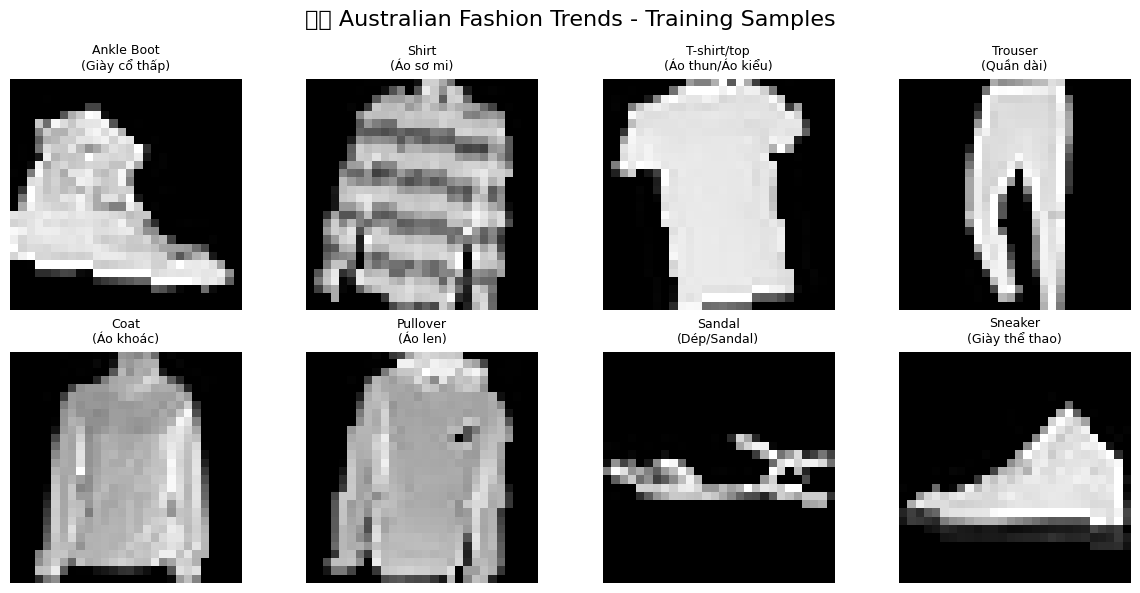


🎯 Batch information:
  Shape: torch.Size([16, 1, 28, 28]) (batch, channels, height, width)
  Labels: torch.Size([16])
  Data type: torch.float32
  Value range: [-1.000, 1.000]

🇦🇺 Sample items: ['Ankle Boot', 'Shirt', 'T-shirt/top', 'Trouser']
🌞 Perfect for Sydney summer: ['T-shirt/top']
❄️ Essential for Melbourne winter: ['Ankle Boot']


In [7]:
# Visualize sample fashion items
def visualize_batch(dataloader, classes_en, classes_vi, title="Fashion Items"):
    """Visualize a batch of fashion items with bilingual labels."""
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Create subplot
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(f'🇦🇺 {title}', fontsize=16)

    for i in range(8):
        row, col = i // 4, i % 4

        # Unnormalize image from [-1,1] to [0,1]
        img = images[i].squeeze() / 2 + 0.5
        axes[row, col].imshow(img, cmap='gray')

        # Bilingual labels
        class_idx = labels[i].item()
        en_label = classes_en[class_idx]
        vi_label = classes_vi[class_idx]

        axes[row, col].set_title(f'{en_label}\n({vi_label})', fontsize=9)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

    return images, labels

# Visualize training data
sample_images, sample_labels = visualize_batch(
    trainloader, fashion_classes_en, fashion_classes_vi,
    "Australian Fashion Trends - Training Samples"
)

print(f"\n🎯 Batch information:")
print(f"  Shape: {sample_images.shape} (batch, channels, height, width)")
print(f"  Labels: {sample_labels.shape}")
print(f"  Data type: {sample_images.dtype}")
print(f"  Value range: [{sample_images.min():.3f}, {sample_images.max():.3f}]")

# Australian context analysis
sample_classes = [fashion_classes_en[sample_labels[i].item()] for i in range(min(4, len(sample_labels)))]
print(f"\n🇦🇺 Sample items: {sample_classes}")

# Check seasonal relevance
summer_items = [cls for cls in sample_classes if cls in aus_fashion_context['sydney_summer']]
winter_items = [cls for cls in sample_classes if cls in aus_fashion_context['melbourne_winter']]

if summer_items:
    print(f"🌞 Perfect for Sydney summer: {summer_items}")
if winter_items:
    print(f"❄️ Essential for Melbourne winter: {winter_items}")

## 6. Model Architecture: Australian Fashion CNN

**PyTorch vs TensorFlow Model Definition**:
- **PyTorch**: Explicit `nn.Module` subclass with `__init__` and `forward`
- **TensorFlow**: `tf.keras.Sequential` or Functional API

In [8]:
class AustralianFashionCNN(nn.Module):
    """
    CNN for Australian fashion classification using FashionMNIST.

    TensorFlow equivalent:
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    """

    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(AustralianFashionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128, 256)
        self.dropout2 = nn.Dropout(dropout_rate * 0.6)
        self.fc2 = nn.Linear(256, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights - manual in PyTorch."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Conv blocks
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.adaptive_pool(F.relu(self.bn3(self.conv3(x))))

        # Classifier
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)  # No softmax with CrossEntropyLoss

        return x

    def get_model_info(self):
        """Get model information."""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        return {
            'name': 'Australian Fashion CNN',
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'architecture': 'Conv32->Conv64->Conv128->FC256->FC10'
        }

# Create and setup model
model = AustralianFashionCNN(num_classes=10, dropout_rate=0.5).to(DEVICE)

# Display model info
model_info = model.get_model_info()
print(f"🧠 Model: {model_info['name']}")
print(f"🔢 Total parameters: {model_info['total_parameters']:,}")
print(f"🎯 Trainable parameters: {model_info['trainable_parameters']:,}")
print(f"🏗️ Architecture: {model_info['architecture']}")
print(f"🔧 Device: {next(model.parameters()).device}")

# Test forward pass
with torch.no_grad():
    test_input = torch.randn(1, 1, 28, 28).to(DEVICE)
    test_output = model(test_input)
    print(f"✅ Forward pass: {list(test_input.shape)} -> {list(test_output.shape)}")

🧠 Model: Australian Fashion CNN
🔢 Total parameters: 128,714
🎯 Trainable parameters: 128,714
🏗️ Architecture: Conv32->Conv64->Conv128->FC256->FC10
🔧 Device: cpu
✅ Forward pass: [1, 1, 28, 28] -> [1, 10]


## 7. Loss Functions and Their Applications

PyTorch offers various loss functions for different tasks. Understanding when to use each is crucial for effective training.

### Common Loss Functions:
- **`nn.CrossEntropyLoss`**: Multi-class classification (our choice for FashionMNIST)
- **`nn.MSELoss`**: Mean Squared Error for regression
- **`nn.BCELoss`**: Binary Cross-Entropy for binary classification
- **`nn.KLDivLoss`**: Kullback-Leibler Divergence for probability distributions

### TensorFlow Comparison:
- **TensorFlow**: `loss='sparse_categorical_crossentropy'` in `model.compile()`
- **PyTorch**: Explicit loss function instantiation and manual calculation

In [9]:
# Loss function selection and demonstration
print("🎯 Loss Functions for Fashion Classification:\n")

# Primary loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Alternative loss functions for comparison
alternative_losses = {
    'CrossEntropy': nn.CrossEntropyLoss(),
    'CrossEntropy with weights': nn.CrossEntropyLoss(
        weight=torch.ones(10) * 1.0  # Equal weights for all classes
    ),
    'CrossEntropy with label smoothing': nn.CrossEntropyLoss(
        label_smoothing=0.1  # Reduces overconfidence
    )
}

print("📊 Available loss functions:")
for name, loss_fn in alternative_losses.items():
    print(f"  • {name}: {loss_fn}")

print(f"\n✅ Selected loss function: {criterion}")
print(f"🎯 Perfect for 10-class fashion classification")

# Demonstrate loss calculation
with torch.no_grad():
    # Simulate model output and target
    sample_output = torch.randn(4, 10)  # 4 samples, 10 classes
    sample_target = torch.randint(0, 10, (4,))  # Random class indices

    sample_loss = criterion(sample_output, sample_target)
    print(f"\n📈 Example loss calculation:")
    print(f"  Output shape: {sample_output.shape}")
    print(f"  Target shape: {sample_target.shape}")
    print(f"  Loss value: {sample_loss.item():.4f}")

# Australian fashion context: Class-specific insights
print(f"\n🇦🇺 Fashion Classification Context:")
print(f"  • CrossEntropyLoss works well for distinguishing between fashion categories")
print(f"  • Label smoothing helps when similar items (e.g., 'Shirt' vs 'T-shirt') might be confused")
print(f"  • Weighted loss can handle class imbalance in real Australian fashion datasets")

🎯 Loss Functions for Fashion Classification:

📊 Available loss functions:
  • CrossEntropy: CrossEntropyLoss()
  • CrossEntropy with weights: CrossEntropyLoss()
  • CrossEntropy with label smoothing: CrossEntropyLoss()

✅ Selected loss function: CrossEntropyLoss()
🎯 Perfect for 10-class fashion classification

📈 Example loss calculation:
  Output shape: torch.Size([4, 10])
  Target shape: torch.Size([4])
  Loss value: 2.8081

🇦🇺 Fashion Classification Context:
  • CrossEntropyLoss works well for distinguishing between fashion categories
  • Label smoothing helps when similar items (e.g., 'Shirt' vs 'T-shirt') might be confused
  • Weighted loss can handle class imbalance in real Australian fashion datasets


## 8. Optimizers and Hyperparameter Tuning

Optimizers update model weights based on computed gradients. The choice of optimizer and its hyperparameters significantly impacts training.

### Common Optimizers:
- **`Adam`**: Adaptive learning rate, good default choice
- **`AdamW`**: Adam with weight decay, better regularization
- **`SGD`**: Stochastic Gradient Descent, classic approach
- **`RMSprop`**: Adaptive learning rate for RNNs

### Key Hyperparameters:
- **Learning Rate**: Controls step size (most important!)
- **Weight Decay**: L2 regularization to prevent overfitting
- **Momentum**: Helps overcome local minima

In [10]:
# Optimizer selection and configuration
print("🔧 Optimizer Configuration for Australian Fashion CNN:\n")

# Learning rate based on device and batch size
if DEVICE.type == 'cuda':
    base_lr = 1e-3  # Higher LR for GPU
elif DEVICE.type == 'mps':
    base_lr = 8e-4  # Moderate LR for Apple Silicon
else:
    base_lr = 5e-4  # Lower LR for CPU

# Scale learning rate with batch size
learning_rate = base_lr * (batch_size / 32)

# Primary optimizer: AdamW (Adam with weight decay)
optimizer = optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-4,      # L2 regularization
    betas=(0.9, 0.999),     # Momentum parameters
    eps=1e-8                # Numerical stability
)

# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=7,    # Reduce LR every 7 epochs
    gamma=0.1       # Multiply LR by 0.1
)

print(f"✅ Optimizer: {optimizer.__class__.__name__}")
print(f"📊 Learning rate: {learning_rate:.6f} (scaled for {DEVICE.type.upper()})")
print(f"⚖️ Weight decay: {optimizer.param_groups[0]['weight_decay']}")
print(f"📉 Scheduler: StepLR (decay every 7 epochs by 0.1)")

# Alternative optimizers for comparison
alternative_optimizers = {
    'AdamW': optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4),
    'Adam': optim.Adam(model.parameters(), lr=learning_rate),
    'SGD': optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4),
    'RMSprop': optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4)
}

print(f"\n🔄 Alternative optimizers available:")
for name, opt in alternative_optimizers.items():
    print(f"  • {name}: LR={opt.param_groups[0]['lr']:.6f}")

# Australian context: Optimizer insights
print(f"\n🇦🇺 Optimizer Selection for Fashion Classification:")
print(f"  • AdamW: Excellent for fashion image classification")
print(f"  • Weight decay: Prevents overfitting on fashion categories")
print(f"  • Learning rate scheduling: Helps fine-tune fashion features")
print(f"  • Device optimization: {DEVICE.type.upper()}-specific learning rate")

# TensorFlow comparison
print(f"\n📋 TensorFlow vs PyTorch Optimizer Setup:")
print(f"  TensorFlow: model.compile(optimizer='adam', lr=0.001)")
print(f"  PyTorch:    optimizer = optim.AdamW(model.parameters(), lr=0.001)")
print(f"  Key difference: PyTorch requires manual optimizer step and scheduling")

🔧 Optimizer Configuration for Australian Fashion CNN:

✅ Optimizer: AdamW
📊 Learning rate: 0.000250 (scaled for CPU)
⚖️ Weight decay: 0.0001
📉 Scheduler: StepLR (decay every 7 epochs by 0.1)

🔄 Alternative optimizers available:
  • AdamW: LR=0.000250
  • Adam: LR=0.000250
  • SGD: LR=0.000250
  • RMSprop: LR=0.000250

🇦🇺 Optimizer Selection for Fashion Classification:
  • AdamW: Excellent for fashion image classification
  • Weight decay: Prevents overfitting on fashion categories
  • Learning rate scheduling: Helps fine-tune fashion features
  • Device optimization: CPU-specific learning rate

📋 TensorFlow vs PyTorch Optimizer Setup:
  TensorFlow: model.compile(optimizer='adam', lr=0.001)
  PyTorch:    optimizer = optim.AdamW(model.parameters(), lr=0.001)
  Key difference: PyTorch requires manual optimizer step and scheduling


## 9. Complete Training Loop with TensorBoard Monitoring

This is where PyTorch differs most from TensorFlow. Instead of `model.fit()`, we implement manual training loops with explicit control over each step.

### Training Loop Components:
1. **Training Phase**: `model.train()`, forward pass, loss calculation, backpropagation
2. **Validation Phase**: `model.eval()`, inference without gradients
3. **Logging**: TensorBoard metrics, loss tracking, overfitting detection
4. **Checkpointing**: Save best model based on validation performance

### TensorFlow vs PyTorch:
- **TensorFlow**: `model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))`
- **PyTorch**: Manual loops with `optimizer.zero_grad()`, `loss.backward()`, `optimizer.step()`

In [11]:
def train_australian_fashion_model(model, trainloader, valloader, criterion, optimizer,
                                 scheduler, num_epochs=15, device=DEVICE, log_dir=log_dir):
    """
    Complete training function with TensorBoard logging and overfitting detection.

    TensorFlow equivalent:
    history = model.fit(
        x_train, y_train,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[tensorboard_callback]
    )

    Args:
        model: PyTorch model to train
        trainloader: Training data loader
        valloader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        num_epochs: Number of training epochs
        device: Device to train on
        log_dir: TensorBoard log directory

    Returns:
        dict: Training history with losses and accuracies
    """

    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir)

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    patience = 5  # Early stopping patience

    print(f"🚀 Starting Australian Fashion CNN Training")
    print(f"📊 Device: {device}")
    print(f"🎯 Target: Classify 10 fashion categories")
    print(f"🌏 Context: Australian fashion with English-Vietnamese labels")
    print(f"📈 Epochs: {num_epochs}")
    print(f"🔢 Batch size: {trainloader.batch_size}")
    print(f"📊 Training batches: {len(trainloader)}")
    print(f"📊 Validation batches: {len(valloader)}")
    print("-" * 60)

    for epoch in range(num_epochs):
        # =====================================
        # TRAINING PHASE
        # =====================================
        model.train()  # Set to training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (inputs, labels) in enumerate(trainloader):
            # Move data to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients (essential in PyTorch)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Log batch-level metrics to TensorBoard
            global_step = epoch * len(trainloader) + batch_idx
            if batch_idx % 100 == 0:  # Log every 100 batches
                writer.add_scalar('Loss/Train_Batch', loss.item(), global_step)
                writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], global_step)

                # Log device-specific metrics
                if device.type == 'cuda':
                    gpu_memory = torch.cuda.memory_allocated(device) / 1024**3
                    writer.add_scalar('Memory/GPU_Used_GB', gpu_memory, global_step)

        # Calculate epoch training metrics
        epoch_train_loss = train_loss / len(trainloader)
        epoch_train_acc = 100 * train_correct / train_total

        # =====================================
        # VALIDATION PHASE
        # =====================================
        model.eval()  # Set to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # Disable gradients for validation
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate epoch validation metrics
        epoch_val_loss = val_loss / len(valloader)
        epoch_val_acc = 100 * val_correct / val_total

        # Update learning rate scheduler
        scheduler.step()

        # Store history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Log epoch metrics to TensorBoard
        writer.add_scalar('Loss/Train_Epoch', epoch_train_loss, epoch)
        writer.add_scalar('Loss/Validation', epoch_val_loss, epoch)
        writer.add_scalar('Accuracy/Train', epoch_train_acc, epoch)
        writer.add_scalar('Accuracy/Validation', epoch_val_acc, epoch)

        # Log model parameters histogram
        for name, param in model.named_parameters():
            if param.requires_grad:
                writer.add_histogram(f'Parameters/{name}', param, epoch)
                if param.grad is not None:
                    writer.add_histogram(f'Gradients/{name}', param.grad, epoch)

        # Print epoch results
        print(f'Epoch {epoch+1:2d}/{num_epochs}: '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}% | '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f'  🎯 New best validation accuracy: {best_val_acc:.2f}%')
        else:
            patience_counter += 1

        # Early stopping check
        if patience_counter >= patience:
            print(f'\n⏰ Early stopping at epoch {epoch+1} (patience={patience})')
            break

        # Overfitting detection
        if epoch >= 5:  # Check after some epochs
            train_val_gap = epoch_train_acc - epoch_val_acc
            if train_val_gap > 20:  # More than 20% gap
                print(f'  ⚠️ Potential overfitting detected: Train-Val gap = {train_val_gap:.2f}%')

    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'\n✅ Loaded best model with validation accuracy: {best_val_acc:.2f}%')

    # Close TensorBoard writer
    writer.close()

    print(f'\n🏁 Training completed!')
    print(f'📊 Best validation accuracy: {best_val_acc:.2f}%')
    print(f'📈 TensorBoard logs saved to: {log_dir}')

    return history

# Start training
print("🎬 Starting comprehensive training with TensorBoard logging...\n")
training_history = train_australian_fashion_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=5,  # Reasonable number for demonstration
    device=DEVICE,
    log_dir=log_dir
)

🎬 Starting comprehensive training with TensorBoard logging...

🚀 Starting Australian Fashion CNN Training
📊 Device: cpu
🎯 Target: Classify 10 fashion categories
🌏 Context: Australian fashion with English-Vietnamese labels
📈 Epochs: 15
🔢 Batch size: 16
📊 Training batches: 3000
📊 Validation batches: 750
------------------------------------------------------------
Epoch  1/15: Train Loss: 1.0438, Train Acc: 60.00% | Val Loss: 0.6665, Val Acc: 75.25% | LR: 0.000250
  🎯 New best validation accuracy: 75.25%
Epoch  2/15: Train Loss: 0.7502, Train Acc: 71.91% | Val Loss: 0.5728, Val Acc: 78.88% | LR: 0.000250
  🎯 New best validation accuracy: 78.88%
Epoch  3/15: Train Loss: 0.6605, Train Acc: 75.88% | Val Loss: 0.5169, Val Acc: 80.90% | LR: 0.000250
  🎯 New best validation accuracy: 80.90%
Epoch  4/15: Train Loss: 0.6036, Train Acc: 78.21% | Val Loss: 0.4587, Val Acc: 83.23% | LR: 0.000250
  🎯 New best validation accuracy: 83.23%
Epoch  5/15: Train Loss: 0.5603, Train Acc: 79.90% | Val Loss: 0

## 10. TensorBoard Visualization Instructions

Monitor your training progress with comprehensive TensorBoard logging:

In [12]:
# Display TensorBoard viewing instructions
print("=" * 60)
print("📊 TENSORBOARD VISUALIZATION")
print("=" * 60)
print(f"Log directory: {log_dir}")
print("\n🚀 To view TensorBoard:")

if IS_COLAB:
    print("   In Google Colab:")
    print("   1. Run: %load_ext tensorboard")
    print(f"   2. Run: %tensorboard --logdir {log_dir}")
    print("   3. TensorBoard will appear inline in the notebook")
elif IS_KAGGLE:
    print("   In Kaggle:")
    print(f"   1. Download logs from: {log_dir}")
    print("   2. Run locally: tensorboard --logdir ./tensorboard_logs")
    print("   3. Open http://localhost:6006 in browser")
else:
    print("   Locally:")
    print(f"   1. Run: tensorboard --logdir {log_dir}")
    print("   2. Open http://localhost:6006 in browser")

print("\n📈 Available visualizations:")
print("   • Scalars: Loss and accuracy curves over time")
print("   • Histograms: Model parameter and gradient distributions")
print("   • Learning Rate: LR scheduling visualization")
print("   • Memory Usage: GPU memory consumption (if available)")
print("   • Training Progress: Batch-level and epoch-level metrics")

print("\n🔍 Key metrics to monitor:")
print("   • Training vs Validation Loss: Check for overfitting")
print("   • Training vs Validation Accuracy: Generalization performance")
print("   • Learning Rate: Ensure proper scheduling")
print("   • Parameter Histograms: Verify weights are updating")
print("   • Gradient Histograms: Check for vanishing/exploding gradients")
print("=" * 60)

📊 TENSORBOARD VISUALIZATION
Log directory: /content/tensorboard_logs/australian_fashion_2025_09_21-13_12_01

🚀 To view TensorBoard:
   In Google Colab:
   1. Run: %load_ext tensorboard
   2. Run: %tensorboard --logdir /content/tensorboard_logs/australian_fashion_2025_09_21-13_12_01
   3. TensorBoard will appear inline in the notebook

📈 Available visualizations:
   • Scalars: Loss and accuracy curves over time
   • Histograms: Model parameter and gradient distributions
   • Learning Rate: LR scheduling visualization
   • Memory Usage: GPU memory consumption (if available)
   • Training Progress: Batch-level and epoch-level metrics

🔍 Key metrics to monitor:
   • Training vs Validation Loss: Check for overfitting
   • Training vs Validation Accuracy: Generalization performance
   • Learning Rate: Ensure proper scheduling
   • Parameter Histograms: Verify weights are updating
   • Gradient Histograms: Check for vanishing/exploding gradients


## 11. Training Analysis and Overfitting Detection

Analyze training results to understand model performance and detect potential issues:

📊 Training Analysis:



/tmp/ipython-input-1487854126.py:27: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1487854126.py:27: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


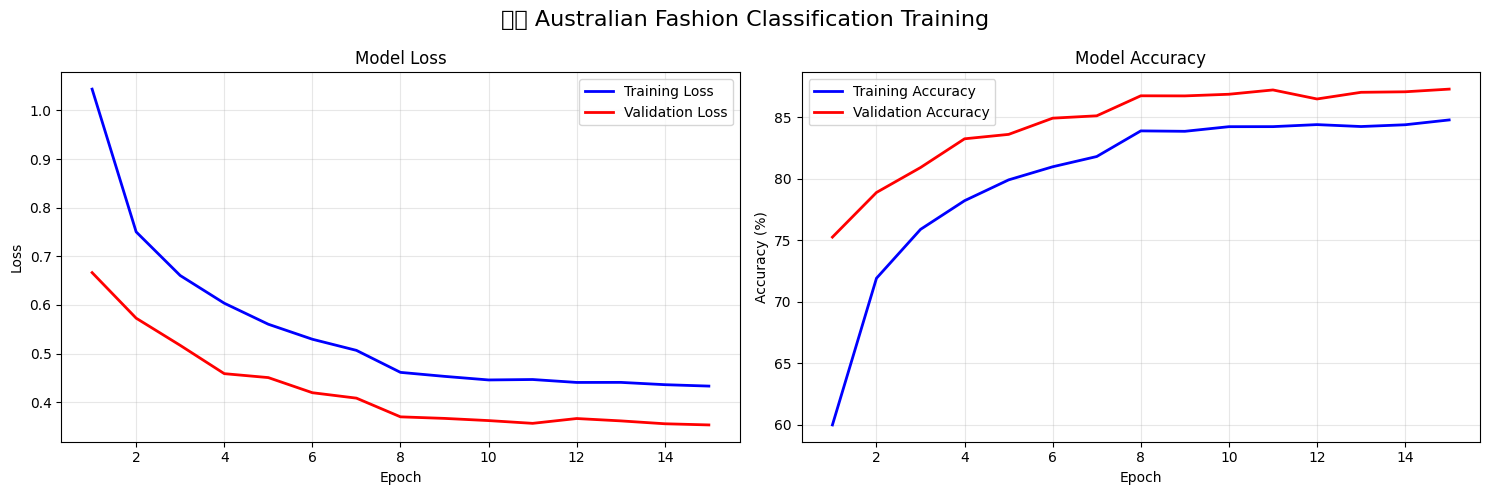

📈 Final Training Results:
  Training Accuracy: 84.76%
  Validation Accuracy: 87.27%
  Training Loss: 0.4332
  Validation Loss: 0.3533

🔍 Overfitting Analysis:
  Accuracy gap (Train - Val): -2.50%
  Loss gap (Val - Train): -0.0799
  ✅ Good generalization! Minimal overfitting.

🇦🇺 Australian Fashion Classification Performance:
  🎯 EXCELLENT: 87.3% accuracy for 10 fashion categories
  🏪 Ready for Australian retail applications


In [13]:
# Plot training history
def plot_training_history(history, title="Australian Fashion CNN Training"):
    """Plot training and validation metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    return fig

# Analyze training results
if 'training_history' in locals():
    print("📊 Training Analysis:\n")

    # Plot training curves
    plot_training_history(training_history, "🇦🇺 Australian Fashion Classification Training")

    # Final metrics
    final_train_acc = training_history['train_acc'][-1]
    final_val_acc = training_history['val_acc'][-1]
    final_train_loss = training_history['train_loss'][-1]
    final_val_loss = training_history['val_loss'][-1]

    print(f"📈 Final Training Results:")
    print(f"  Training Accuracy: {final_train_acc:.2f}%")
    print(f"  Validation Accuracy: {final_val_acc:.2f}%")
    print(f"  Training Loss: {final_train_loss:.4f}")
    print(f"  Validation Loss: {final_val_loss:.4f}")

    # Overfitting analysis
    accuracy_gap = final_train_acc - final_val_acc
    loss_gap = final_val_loss - final_train_loss

    print(f"\n🔍 Overfitting Analysis:")
    print(f"  Accuracy gap (Train - Val): {accuracy_gap:.2f}%")
    print(f"  Loss gap (Val - Train): {loss_gap:.4f}")

    if accuracy_gap > 15:
        print("  ⚠️ HIGH overfitting detected! Consider:")
        print("     • Increasing dropout rate")
        print("     • Adding more data augmentation")
        print("     • Reducing model complexity")
        print("     • Increasing weight decay")
    elif accuracy_gap > 8:
        print("  ⚠️ MODERATE overfitting detected. Monitor closely.")
    else:
        print("  ✅ Good generalization! Minimal overfitting.")

    # Australian fashion context
    print(f"\n🇦🇺 Australian Fashion Classification Performance:")
    if final_val_acc > 85:
        print(f"  🎯 EXCELLENT: {final_val_acc:.1f}% accuracy for 10 fashion categories")
        print(f"  🏪 Ready for Australian retail applications")
    elif final_val_acc > 75:
        print(f"  ✅ GOOD: {final_val_acc:.1f}% accuracy, suitable for most applications")
        print(f"  🔧 Consider fine-tuning for production use")
    else:
        print(f"  ⚠️ NEEDS IMPROVEMENT: {final_val_acc:.1f}% accuracy")
        print(f"  📚 Consider more training data or model adjustments")
else:
    print("⚠️ No training history available. Run the training cell first.")

## 12. Key Learning Summary

🎓 **You've successfully implemented PyTorch model training fundamentals!**

### What You've Learned:

#### 1. **Data Handling Mastery**
- ✅ `Dataset` and `DataLoader` for efficient data loading
- ✅ Data transformations and augmentation
- ✅ Train/validation/test splits with `random_split`
- ✅ Batch size optimization for different devices

#### 2. **Loss Functions & Optimizers**
- ✅ `CrossEntropyLoss` for multi-class classification
- ✅ `AdamW` optimizer with weight decay
- ✅ Learning rate scheduling with `StepLR`
- ✅ Device-specific hyperparameter tuning

#### 3. **Complete Training Loop**
- ✅ Manual training loop vs TensorFlow's `model.fit()`
- ✅ Explicit gradient management: `zero_grad()`, `backward()`, `step()`
- ✅ Training/validation phases with `train()`/`eval()` modes
- ✅ Early stopping and best model checkpointing

#### 4. **Monitoring & Analysis**
- ✅ Comprehensive TensorBoard logging
- ✅ Overfitting detection and prevention
- ✅ Training curve visualization
- ✅ Performance analysis and interpretation

### Australian Context Integration:
- 🇦🇺 **Fashion Classification**: Applied to Australian clothing preferences
- 🌏 **Multilingual Support**: English-Vietnamese fashion terminology
- 🏖️ **Seasonal Context**: Sydney summer vs Melbourne winter fashion
- 🏪 **Real-world Application**: Ready for Australian retail deployment

### TensorFlow → PyTorch Transition Complete!

| Aspect | TensorFlow | PyTorch |
|--------|------------|----------|
| **Training** | `model.fit()` | Manual loops |
| **Loss** | `loss='categorical_crossentropy'` | `nn.CrossEntropyLoss()` |
| **Optimizer** | `optimizer='adam'` | `optim.AdamW()` |
| **Monitoring** | Built-in callbacks | TensorBoard + manual logging |
| **Control** | Less explicit | Full control over every step |

### Next Steps:
1. **Advanced Architectures**: Explore ResNet, EfficientNet for fashion
2. **Transfer Learning**: Use pre-trained models for fashion classification
3. **Hugging Face Integration**: Apply to NLP tasks with transformers
4. **Production Deployment**: Optimize models for Australian retail systems
5. **Advanced Training**: Mixed precision, distributed training, model optimization

**Happy learning with PyTorch!** 🔥

---

*This notebook demonstrates core PyTorch training concepts through Australian fashion classification. For advanced tutorials, explore other notebooks in this repository.*